In [52]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e ds-assets && cd ds-assets && git pull && cd ..
# if it is not installed clone it 
!test ! -e ds-assets && git clone https://github.com/lutzhamel/ds-assets.git
# point to the folder with the assets
home = "ds-assets/assets/" 
import sys
sys.path.append(home)      # add home folder to module search path

Already up to date.


# NLP & ML: Clustering

Here we try something different from ML - we will cluster our news articale data set using kmeans.  The idea would be that we can recover the two main clusters: science and politics.

## Data

In [53]:
# setup
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from elbow import plot_elbow
from sklearn.cluster import KMeans


In [54]:
print("******** data **********")

# get the newsgroup database
newsgroups = pd.read_csv(home+"newsgroups-noheaders.csv")
#newsgroups = pd.read_csv(home+"newsgroups.csv")
newsgroups.head(n=10)

******** data **********


,text,label
0,\nIn billions of dollars (%GNP):\nyear GNP ...,space
1,ajteel@dendrite.cs.Colorado.EDU (A.J. Teel) w...,space
2,\nMy opinion is this: In a society whose econ...,space
3,"Ahhh, remember the days of Yesterday? When we...",space
4,"\n""...a la Chrysler""?? Okay kids, to the near...",space
5,"\n As for advertising -- sure, why not? A N...",politics
6,"\n What, pray tell, does this mean? Just who ...",space
7,\nWhere does the shadow come from? There's no...,politics
8,^^^^^^^^^...,politics
9,"#Yet, when a law was proposed for Virginia tha...",space


In [55]:
print("******** docarray **********")

# build the stemmer object
stemmer = PorterStemmer()

# build a new default analyzer using CountVectorizer that only uses words: [a-zA-Z]+
# also eliminate stop words
analyzer= CountVectorizer(analyzer = "word", 
                          stop_words = 'english',
                          token_pattern = "[a-zA-Z]+").build_analyzer()

# build a new analyzer that stems using the default analyzer to create the words to be stemmed
def stemmed_words(doc):
    return [stemmer.stem(w) for w in analyzer(doc)]

# build docarray -- in order to make the clustering a bit more tractable we 
# require that each word in the coordinate system appears at least in 10% (min_df = .1)
# of the document collection
vectorizer = CountVectorizer(analyzer=stemmed_words,
                             #analyzer=analyzer,
                             binary=True,
                             min_df=.1) 
docarray = vectorizer.fit_transform(newsgroups['text']).toarray()
print(docarray.shape)
doc_df = pd.DataFrame(docarray, columns=list(vectorizer.get_feature_names_out()))
doc_df.head()

******** docarray **********
(1038, 55)


,actual,base,believ,case,come,cost,d,day,did,differ,...,thing,think,time,tri,use,ve,want,way,work,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,1,0,1,1
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Notice that we are down to 55 dimensions!

## Model

Next we have to look at the optimal number of k for our kmeans algorithm.  We use the elbow method.

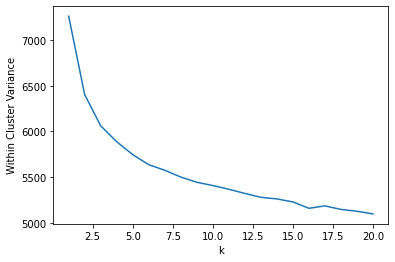

In [56]:
# generate elbow plot
plot_elbow(doc_df,20)

In [57]:
# fit the model with a k picked from above
k=5
model = KMeans(n_clusters=k,random_state=10)
model.fit(doc_df)
labels = model.labels_ # cluster member ship of each document in the training data
# show the cluster membership of the first 100 documents.
labels[:100]

array([0, 0, 2, 2, 0, 2, 2, 3, 3, 3, 3, 3, 0, 0, 2, 3, 1, 0, 2, 0, 0, 4,
       0, 2, 0, 0, 1, 4, 0, 3, 3, 0, 1, 2, 0, 3, 0, 4, 3, 3, 0, 0, 0, 3,
       0, 1, 3, 3, 1, 0, 0, 0, 1, 0, 3, 1, 1, 2, 3, 1, 1, 1, 3, 3, 1, 1,
       1, 3, 0, 0, 3, 3, 2, 2, 0, 0, 0, 0, 2, 0, 3, 4, 1, 0, 1, 3, 0, 0,
       0, 1, 4, 2, 1, 1, 3, 0, 2, 2, 0, 1], dtype=int32)

## Model Evaluation

In [58]:
# create a data frame that has both the given labels and the predicted cluster number for each document
both_labels_df = pd.DataFrame(data=[labels,newsgroups['label']],index=['predicted','given']).T
both_labels_df.head(n=100)

,predicted,given
0,0,space
1,0,space
2,2,space
3,2,space
4,0,space
...,...,...
95,0,politics
96,2,space
97,2,politics
98,0,politics


In [59]:
# convert the cluster number into a label -- we do this by looking at all the 
# given labels within a cluster and select the majority label as the label 
# for the cluster

majority_labels = dict()

k = model.cluster_centers_.shape[0]

for i in range(k):
  # create a dataframe that only has documents for cluster i
  cnt_df = both_labels_df[both_labels_df['predicted'] == i]
  # count how many documents of type 'space' are in cluster i
  space_cnt = cnt_df[cnt_df['given'] == 'space'].shape[0]
  # count how many documents of type 'politics' are in cluster i
  politics_cnt = cnt_df[cnt_df['given'] == 'politics'].shape[0]
  # the label with the highest count become the majority label
  # for cluster i
  label = "space" if space_cnt >= politics_cnt else "politics"
  majority_labels.update({i:label})

majority_labels

{0: 'politics', 1: 'politics', 2: 'space', 3: 'politics', 4: 'space'}

In [60]:
# convert cluster number to a label

# f maps cluster number x to its majority label
def f(x): 
  return majority_labels[x]

# apply f to the dataframe
predicted_labels_df = both_labels_df.copy()
predicted_labels_df['predicted'] = predicted_labels_df['predicted'].apply(f)
predicted_labels_df


,predicted,given
0,politics,space
1,politics,space
2,space,space
3,space,space
4,politics,space
...,...,...
1033,politics,politics
1034,politics,space
1035,politics,space
1036,politics,politics


In [61]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from confint import classification_confint


In [62]:
# see how accurate our cluster model is
acc = accuracy_score(predicted_labels_df['given'], predicted_labels_df['predicted'])
lb,ub = classification_confint(acc,docarray.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc,lb,ub))

Accuracy: 0.62 (0.59,0.65)


## Model Centroids

In [63]:
# build a dataframe that contains our centroids
k = model.cluster_centers_.shape[0]
index_list = []

for i in range(k):
  index_list.append(str(i)+':'+majority_labels[i])

centroids = pd.DataFrame(data=model.cluster_centers_,
                         index=index_list,
                         columns=list(vectorizer.get_feature_names_out())).T
centroids

,0:politics,1:politics,2:space,3:politics,4:space
actual,5.555556e-02,0.056338,0.192308,0.121212,0.409091
base,2.777778e-02,0.302817,0.147436,0.037879,0.522727
believ,4.629630e-02,0.049296,0.211538,0.064394,0.613636
case,3.472222e-02,0.133803,0.211538,0.083333,0.568182
come,4.629630e-02,0.105634,0.179487,0.075758,0.613636
cost,2.777778e-02,0.197183,0.179487,0.060606,0.454545
d,5.092593e-02,0.246479,0.288462,0.113636,0.727273
day,4.861111e-02,0.204225,0.134615,0.049242,0.659091
did,4.629630e-02,0.084507,0.269231,0.121212,0.590909
differ,3.472222e-02,0.147887,0.230769,0.075758,0.545455


In [64]:
# threshold the centroids so it is easier to see which words are important
centroids = centroids.applymap(lambda x: 0 if x < .5 else 1)
centroids

,0:politics,1:politics,2:space,3:politics,4:space
actual,0,0,0,0,0
base,0,0,0,0,1
believ,0,0,0,0,1
case,0,0,0,0,1
come,0,0,0,0,1
cost,0,0,0,0,0
d,0,0,0,0,1
day,0,0,0,0,1
did,0,0,0,0,1
differ,0,0,0,0,1
